# Tensorflow DNN - Earlystopping

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

## prepare dataset examples

  classname                         img
0       c34  marge_simpson/pic_0601.jpg
1       c34  marge_simpson/pic_0180.jpg
2       c34  marge_simpson/pic_0196.jpg
3       c34  marge_simpson/pic_0698.jpg
4       c34  marge_simpson/pic_0083.jpg
[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 ..., 
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]


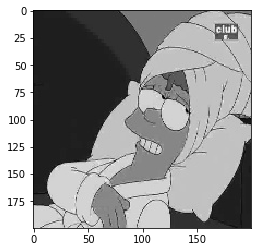

In [4]:
img_src = '/data/examples/simpson_preproc/'

simpson_img = pd.read_csv(img_src + 'simpson_img_list.csv')
print(simpson_img.head())

img = cv2.imread(img_src + simpson_img.img.iloc[0], 0)
plt.imshow(img, cmap='gray')

simpson_img = simpson_img[simpson_img.img.str.contains('simpson')] # filter data

simpson_y = pd.get_dummies(simpson_img['classname'], '').as_matrix() # transform y to one-hot encoder format
print(simpson_y) 

## split dataset to training data and testing data

In [5]:
x_train_list, x_test_list, y_train, y_test = train_test_split(simpson_img, simpson_y, test_size=0.1)  ## 將 input_x 和 input_y 各自區分成 training data 和 testing data

## record the dim of img ##
img = cv2.resize(img, (50,50))
img = img.flatten()

print('input_data shape: training {training_shape} ; testing {testing_shape}'.format(
            training_shape=(len(x_train_list), img.shape[0]), 
            testing_shape=(len(x_test_list), img.shape[0])))
print('y_true shape: training {training_shape} ; testing {testing_shape}'.format(
            training_shape=y_train.shape, 
            testing_shape=y_test.shape))

input_data shape: training (6546, 2500) ; testing (728, 2500)
y_true shape: training (6546, 6) ; testing (728, 6)


## define image generator

In [6]:
from sklearn.utils import shuffle 

def simpson_train_batch_generator(x, y, bs, shape):
    x_train = np.array([]).reshape((0, shape))
    y_train = np.array([]).reshape((0, y.shape[1]))
    while True:
        new_ind = shuffle(range(len(x)))
        x = x.take(new_ind)
        y = np.take(y, new_ind, axis=0)
        for i in range(len(x)):
            dir_img = img_src + x.img.iloc[i]
            img = cv2.imread(dir_img, 0)
            img = cv2.resize(img, (50,50))
            x_train = np.row_stack([x_train, img.flatten()])
            y_train = np.row_stack([y_train, y[i]])
            if x_train.shape[0] == bs:
                x_batch = x_train.copy()
                x_batch /= 255.
                y_batch = y_train.copy()
                x_train = np.array([]).reshape((0 ,shape))
                y_train = np.array([]).reshape((0 ,y.shape[1]))        
                yield x_batch, y_batch

def simpson_test_batch_generator(x, shape):
    x_test = np.array([]).reshape((0, shape))
    for i in range(len(x)):
        dir_img = img_src + x.img.iloc[i]
        img = cv2.imread(dir_img, 0)
        img = cv2.resize(img, (50,50))
        x_test = np.row_stack([x_test, img.flatten()])
    x_test /= 255.      
    return x_test

x_test = simpson_test_batch_generator(x_test_list, img.shape[0])

# create graph

In [7]:
#### define placeholder ####
tf.reset_default_graph() ## 重新 build graph 需要跑這行

input_data = tf.placeholder(dtype=tf.float32, 
                           shape=[None, img.shape[0]],
                           name='input_data')

y_true = tf.placeholder(dtype=tf.float32, 
                        shape=[None, y_train.shape[1]],
                        name='y_true')

l2 = tf.placeholder(dtype=tf.float32, name = 'l2_regulizers')

#### define variables(weight/bias) ####
x1 = tf.layers.dense(input_data, 
                     256, 
                     activation=tf.nn.relu, 
                     name='hidden1', 
                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2))
x2 = tf.layers.dense(x1, 
                     128, 
                     activation=tf.nn.relu, 
                     name='hidden2',
                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2))
x3 = tf.layers.dense(x2, 
                     64, 
                     activation=tf.nn.relu, 
                     name='hidden3',
                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2))
out = tf.layers.dense(x3, y_train.shape[1], name='output')

y_pred = tf.nn.softmax(out)

#### calculate loss ####
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=out))

#### optimize variables ####
opt = tf.train.AdamOptimizer(learning_rate=0.001)

reg = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = cross_entropy + tf.reduce_sum(reg)
update = opt.minimize(loss)
    
# grad = opt.compute_gradients(loss)
# update = opt.apply_gradients(grad)

# run session
### we can simply run the session multiple times with different amount of regulizers

In [8]:
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score

epoch = 100 #100
bs = 32
update_per_epoch = 100

patience = 5
n_patience = 0

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

tr_loss = list()
te_loss = list()
tr_acc = list()
te_acc = list()
train_gen = simpson_train_batch_generator(x_train_list, y_train, bs, img.shape[0])

print('start modelling!')

for i in range(epoch):

    #### calculate training loss & update variables ####
    training_loss = 0
    training_acc = 0
    bar = tqdm(range(update_per_epoch))
    for j in bar:

        x_batch, y_batch = next(train_gen)

        tr_pred, training_loss_batch, _ = sess.run([y_pred, loss, update], feed_dict={
            input_data:x_batch,
            y_true:y_batch,
            l2: 0.0005
        })

        training_loss += training_loss_batch

        training_acc_batch = accuracy_score(np.argmax(y_batch, axis=1), np.argmax(tr_pred, axis=1))
        training_acc += training_acc_batch

        if j % 5 == 0:
            pass
            #bar.set_description('loss: %.4g' % training_loss_batch)

    ###
    training_loss /= update_per_epoch
    training_acc /= update_per_epoch

    #### calculate testing data loss ####
    te_pred, testing_loss = sess.run([y_pred, loss], feed_dict={
        input_data:x_test,
        y_true:y_test,
        l2: 0.0
    })

    testing_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(te_pred, axis=1))

    tr_loss.append(training_loss)
    te_loss.append(testing_loss)
    tr_acc.append(training_acc)
    te_acc.append(testing_acc)

    print('epoch {epochs}: training loss {training_loss} ; testing loss {testing_loss}'.format(
            epochs=(i+1), 
            training_loss=training_loss,
            testing_loss=testing_loss))

    # monitor the min validation loss
    if testing_loss > np.min(te_loss):
        n_patience += 1
    else:
        n_patience = 0

    if n_patience >= patience:
        print("The model didn't improve for %i rounds, break it!" % patience)
        break

sess.close()

  0%|          | 0/100 [00:00<?, ?it/s]

start modelling!


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 1: training loss 1.819928959608078 ; testing loss 1.5744819641113281


  1%|          | 1/100 [00:00<00:16,  5.89it/s]

epoch 2: training loss 1.678722529411316 ; testing loss 1.5793876647949219


  1%|          | 1/100 [00:00<00:16,  6.14it/s]

epoch 3: training loss 1.6286146104335786 ; testing loss 1.500683069229126


  1%|          | 1/100 [00:00<00:16,  5.98it/s]

epoch 4: training loss 1.6210863161087037 ; testing loss 1.5468733310699463


  1%|          | 1/100 [00:00<00:15,  6.29it/s]

epoch 5: training loss 1.5896755027770997 ; testing loss 1.4816454648971558


  1%|          | 1/100 [00:00<00:16,  5.98it/s]

epoch 6: training loss 1.553700374364853 ; testing loss 1.4812089204788208


  1%|          | 1/100 [00:00<00:16,  5.85it/s]

epoch 7: training loss 1.5568948423862456 ; testing loss 1.4673585891723633


  1%|          | 1/100 [00:00<00:15,  6.23it/s]

epoch 8: training loss 1.5328661704063415 ; testing loss 1.4628061056137085


  1%|          | 1/100 [00:00<00:17,  5.61it/s]

epoch 9: training loss 1.5154708099365235 ; testing loss 1.4514243602752686


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

epoch 10: training loss 1.5455240607261658 ; testing loss 1.4673391580581665


  1%|          | 1/100 [00:00<00:16,  5.84it/s]

epoch 11: training loss 1.4992773377895354 ; testing loss 1.46364164352417


  1%|          | 1/100 [00:00<00:16,  6.02it/s]

epoch 12: training loss 1.4996286118030548 ; testing loss 1.4839868545532227


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

epoch 13: training loss 1.4992045390605926 ; testing loss 1.452906847000122


  1%|          | 1/100 [00:00<00:16,  6.04it/s]

epoch 14: training loss 1.48102667927742 ; testing loss 1.435479760169983


  1%|          | 1/100 [00:00<00:15,  6.22it/s]

epoch 15: training loss 1.4647957479953766 ; testing loss 1.420944094657898


  1%|          | 1/100 [00:00<00:17,  5.62it/s]

epoch 16: training loss 1.4538663744926452 ; testing loss 1.420273780822754


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

epoch 17: training loss 1.4758038866519927 ; testing loss 1.4369494915008545


  1%|          | 1/100 [00:00<00:17,  5.58it/s]

epoch 18: training loss 1.4557392013072967 ; testing loss 1.416079044342041


  1%|          | 1/100 [00:00<00:17,  5.81it/s]

epoch 19: training loss 1.4224116909503937 ; testing loss 1.4267964363098145


  1%|          | 1/100 [00:00<00:14,  6.67it/s]

epoch 20: training loss 1.424637130498886 ; testing loss 1.4416475296020508


  1%|          | 1/100 [00:00<00:17,  5.77it/s]

epoch 21: training loss 1.4337097382545472 ; testing loss 1.4130443334579468


  1%|          | 1/100 [00:00<00:16,  5.89it/s]

epoch 22: training loss 1.4186841666698455 ; testing loss 1.4159393310546875


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

epoch 23: training loss 1.4085743045806884 ; testing loss 1.5088638067245483


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 24: training loss 1.416320139169693 ; testing loss 1.413023591041565


  1%|          | 1/100 [00:00<00:16,  5.91it/s]

epoch 25: training loss 1.4093946409225464 ; testing loss 1.3956886529922485


  1%|          | 1/100 [00:00<00:18,  5.48it/s]

epoch 26: training loss 1.3957366406917573 ; testing loss 1.3886455297470093


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 27: training loss 1.4229800128936767 ; testing loss 1.422764539718628


  1%|          | 1/100 [00:00<00:17,  5.53it/s]

epoch 28: training loss 1.3729717648029327 ; testing loss 1.3979963064193726


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

epoch 29: training loss 1.4164248764514924 ; testing loss 1.3759009838104248


  1%|          | 1/100 [00:00<00:16,  5.84it/s]

epoch 30: training loss 1.3517722690105438 ; testing loss 1.3680037260055542


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 31: training loss 1.3621144568920136 ; testing loss 1.3742444515228271


  1%|          | 1/100 [00:00<00:17,  5.69it/s]

epoch 32: training loss 1.3455000197887421 ; testing loss 1.3820548057556152


  1%|          | 1/100 [00:00<00:16,  5.95it/s]

epoch 33: training loss 1.3590342009067535 ; testing loss 1.4653741121292114


  1%|          | 1/100 [00:00<00:17,  5.69it/s]

epoch 34: training loss 1.3779976165294647 ; testing loss 1.4274402856826782


100%|██████████| 100/100 [00:17<00:00,  5.79it/s]

epoch 35: training loss 1.3292085802555085 ; testing loss 1.4330979585647583
The model didn't improve for 5 rounds, break it!


Text(0.5,1,'Accuracy')

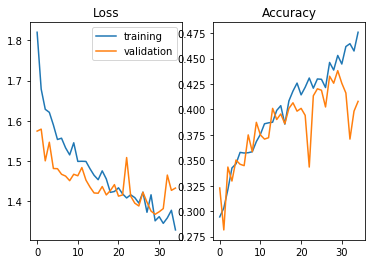

In [10]:
plt.figure(1)
plt.subplot(121)
plt.plot(range(len(tr_loss)), tr_loss, label='training')
plt.plot(range(len(te_loss)), te_loss, label='validation')
plt.title('Loss')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(range(len(tr_acc)), tr_acc, label='training')
plt.plot(range(len(te_acc)), te_acc, label='validation')
plt.title('Accuracy')